In [4]:
!pip install lightfm
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808326 sha256=8536360a1d7e7a291955446050ee9a620238896aa95961b482a6aaf5970f8112
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [5]:
# Load the dataset
df = pd.read_csv('users_tracks_cleaned.csv')

# List of favorite song columns
favorite_song_cols = [f'favorite_song_{i}' for i in range(1, 21)]

# Function to shuffle the songs for each user
def shuffle_songs(row):
    # Extract the user's favorite songs
    songs = row[favorite_song_cols].values
    # Shuffle the songs
    np.random.shuffle(songs)
    # Assign the shuffled songs back to the row
    row[favorite_song_cols] = songs
    return row

# Apply the shuffle function to each user
df = df.apply(shuffle_songs, axis=1)

# Save the reshuffled dataset to a new CSV file
df.to_csv('users_tracks_shuffled.csv', index=False)

print("Dataset has been reshuffled and saved to 'users_tracks_shuffled.csv'.")


Dataset has been reshuffled and saved to 'users_tracks_shuffled.csv'.


In [20]:
num_train_tracks = 15

In [21]:
# Load data
tracks_df = pd.read_csv('cleaned_tracks_dataset.csv')
user_tracks_df = pd.read_csv('users_tracks_shuffled.csv', usecols=range(num_train_tracks + 1))

# Get unique tracks
unique_tracks = tracks_df['track_id'].unique()

# Initialize user-track interaction matrix
user_track_matrix = pd.DataFrame(0, index=user_tracks_df['user_id'], columns=unique_tracks)

# Populate the user-track matrix with user preferences
for index, row in user_tracks_df.iterrows():
    user_id = row['user_id']
    for track_id in row[1:]:
        user_track_matrix.loc[user_id, track_id] = 1

# Fit the NMF model
nmf_model = NMF(n_components=10, init='nndsvd', random_state=42, max_iter=500)
user_factors = nmf_model.fit_transform(user_track_matrix)
track_factors = nmf_model.components_

# Generate predictions
predictions = {}

for user_id in tqdm(user_track_matrix.index, desc="Generating recommendations"):
    # Get the index of the user in the user_factors array
    user_index = user_track_matrix.index.get_loc(user_id)

    # Calculate the user's preference scores for all tracks
    user_preferences = np.dot(user_factors[user_index], track_factors)

    # Get the user's favorite tracks to exclude them from recommendations
    user_fav_tracks = user_tracks_df[user_tracks_df['user_id'] == user_id].values[0][1:]
    user_fav_tracks = set(filter(pd.notnull, user_fav_tracks))

    # Create a list of tracks the user hasn't listened to, along with their predicted scores
    recommendations = [
        (track, score)
        for track, score in zip(user_track_matrix.columns, user_preferences)
        if track not in user_fav_tracks
    ]

    # Sort the recommendations by predicted score in descending order
    top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:20]

    # Store the top 20 recommended track IDs for the user
    predictions[user_id] = [track for track, score in top_recommendations]

# Convert the predictions dictionary to a DataFrame
predictions_df = pd.DataFrame.from_dict(predictions, orient='index')

# Set the column names for the recommendations
predictions_df.columns = [f'rec_{i+1}' for i in range(predictions_df.shape[1])]

# Save the recommendations to a CSV file
predictions_df.to_csv(f'user_recommendations_NMF_{num_train_tracks}.csv', index_label='user')


Generating recommendations: 100%|██████████| 8792/8792 [02:43<00:00, 53.74it/s]


In [22]:
# Load the dataset
df = pd.read_csv('cleaned_tracks_dataset.csv')

# Define the features to be used (excluding categorical features)
features = [
    'track_popularity', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'duration_ms'
]

# Ensure 'track_id' is included in the DataFrame
required_columns = ['track_id'] + features
df = df[required_columns]

# Convert 'track_id' to string to ensure consistency
df['track_id'] = df['track_id'].astype(str)

# Prepare the feature matrix
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the KNN model with a higher number of neighbors
knn = NearestNeighbors(n_neighbors=50, metric='cosine')
knn.fit(X_scaled)

# Function to recommend songs for a single user
def recommend_songs(user_fav_tracks, df, knn_model, scaler):
    # Ensure track IDs are strings
    user_fav_tracks = [str(track_id) for track_id in user_fav_tracks if pd.notnull(track_id)]

    # Get features of the user's favorite tracks
    fav_tracks_features = df[df['track_id'].isin(user_fav_tracks)][features]

    if fav_tracks_features.empty:
        # If favorite tracks are not in the dataset, return a list of None
        return [None] * 20

    # Scale the features of favorite tracks
    fav_tracks_scaled = scaler.transform(fav_tracks_features)

    # Find nearest neighbors
    distances, indices = knn_model.kneighbors(fav_tracks_scaled)

    # Collect recommended track IDs
    recommended_songs = []
    for idx in indices:
        recommended_songs.extend(df.iloc[idx]['track_id'].values)

    # Remove duplicates and already liked tracks
    recommended_songs = np.unique(recommended_songs)
    recommended_songs = [song for song in recommended_songs if song not in user_fav_tracks]

    # Ensure the list has exactly 20 recommendations
    recommendations_padded = recommended_songs[:20]
    recommendations_padded += [None] * (20 - len(recommendations_padded))

    return recommendations_padded

# Load user favorite tracks
user_tracks_df = pd.read_csv('users_tracks_shuffled.csv', usecols=range(num_train_tracks + 1))

# Function to recommend songs for all users
def recommend_for_all_users(user_tracks_df, df, knn_model, scaler):
    predictions = {}

    # Iterate over each user with a progress bar
    for index, row in tqdm(user_tracks_df.iterrows(), total=user_tracks_df.shape[0], desc="Generating recommendations"):
        user_id = row['user_id']
        # Get the user's favorite tracks, ensuring they are strings
        user_fav_tracks = row[1:].astype(str).values
        recommended_songs = recommend_songs(user_fav_tracks, df, knn_model, scaler)
        predictions[user_id] = recommended_songs

    return predictions

# Generate recommendations for all users
predictions = recommend_for_all_users(user_tracks_df, df, knn, scaler)

# Create a DataFrame from the predictions dictionary
columns = [f'rec_{i+1}' for i in range(20)]
predictions_df = pd.DataFrame.from_dict(predictions, orient='index', columns=columns)

# Save the recommendations to a CSV file
predictions_df.to_csv(f'user_recommendations_KNN_{num_train_tracks}.csv', index_label='user')


Generating recommendations: 100%|██████████| 8792/8792 [03:00<00:00, 48.74it/s]


In [23]:
# Load the datasets
cleaned_tracks_dataset = pd.read_csv('cleaned_tracks_dataset.csv')
user_tracks_cleaned = pd.read_csv('users_tracks_shuffled.csv', usecols=range(num_train_tracks + 1))

# Define the features to be used
features = [
    'artistname', 'track_popularity', 'playlist_genre', 'playlist_subgenre',
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'
]

# Prepare track features DataFrame
track_features = cleaned_tracks_dataset[features]
track_features = track_features.set_index(cleaned_tracks_dataset['track_id'])

# Convert track IDs to strings to ensure consistency
track_features.index = track_features.index.astype(str)

# Initialize the graph
G = nx.Graph()

# Get unique user and track IDs
user_ids = user_tracks_cleaned['user_id'].unique()
track_ids = cleaned_tracks_dataset['track_id'].unique()
track_ids = track_ids.astype(str)  # Ensure track IDs are strings

# Add user and track nodes to the graph
for user_id in user_ids:
    G.add_node(user_id, type='user')

for track_id in track_ids:
    G.add_node(track_id, type='track')

# Add edges between users and their favorite tracks
for _, row in user_tracks_cleaned.iterrows():
    user_id = row['user_id']
    # Convert track IDs to strings and filter out NaN values
    favorite_tracks = row[1:].dropna().astype(str).tolist()
    for track_id in favorite_tracks:
        G.add_edge(user_id, track_id)

# Define the recommendation function
def recommend(user_id, G, track_features, top_n=20):
    neighbors = list(G.neighbors(user_id))

    if not neighbors:
        return []

    listened_tracks = [n for n in neighbors if G.nodes[n]['type'] == 'track']
    listened_features = track_features.loc[listened_tracks].values

    # Handle case where listened_features is empty
    if listened_features.size == 0:
        return []

    avg_features = np.mean(listened_features, axis=0)

    # Compute cosine similarity between the average features and all tracks
    similarity_scores = cosine_similarity([avg_features], track_features.values)[0]

    # Get indices of tracks sorted by similarity score in descending order
    sorted_indices = np.argsort(similarity_scores)[::-1]

    recommended_tracks = []
    for idx in sorted_indices:
        track_id = track_features.index[idx]
        if track_id not in listened_tracks:
            recommended_tracks.append(track_id)
        if len(recommended_tracks) >= top_n:
            break

    return recommended_tracks

# Prepare the columns for recommendations
recommendation_columns = [f'rec_{i+1}' for i in range(20)]
user_recommendations_GNN = pd.DataFrame(columns=['user'] + recommendation_columns)

# Generate recommendations for each user with a progress bar
for user_id in tqdm(user_ids, desc="Generating recommendations"):
    recommendations = recommend(user_id, G, track_features)
    rec_dict = {'user': user_id}
    for i in range(20):
        rec_key = f'rec_{i+1}'
        rec_dict[rec_key] = recommendations[i] if i < len(recommendations) else None
    new_row = pd.DataFrame(rec_dict, index=[0])
    user_recommendations_GNN = pd.concat([user_recommendations_GNN, new_row], ignore_index=True)

# Save the recommendations to a CSV file
user_recommendations_GNN.to_csv(f'user_recommendations_GNN_{num_train_tracks}.csv', index=False)


Generating recommendations: 100%|██████████| 8792/8792 [01:12<00:00, 121.62it/s]


In [24]:
# Load the datasets for tracks and user interactions
tracks_df = pd.read_csv('cleaned_tracks_dataset.csv')  # Dataset containing track information
users_df = pd.read_csv('users_tracks_shuffled.csv')     # Dataset containing user-track interactions

# Set the number of recommendations to generate for each user
num_recommendations = 20

# Create a Dataset object for preparing data for the LightFM model
dataset = Dataset()

# Fit the dataset with unique user and track IDs
dataset.fit(
    users_df['user_id'].unique(),   # Unique user IDs
    tracks_df['track_id'].unique()  # Unique track IDs
)

# Select track features to be used in the model
track_features = tracks_df[['track_id', 'danceability', 'energy', 'key', 'loudness', 'mode',
                            'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                            'valence', 'tempo', 'duration_ms']]

# Set 'track_id' as the index for the features dataframe
track_features = track_features.set_index('track_id')

# Binarize track features based on their median values
track_features_binary = track_features.apply(lambda x: (x > x.median()).astype(int))

# Update the dataset with item (track) features
dataset.fit_partial(
    items=track_features_binary.index,          # Track IDs
    item_features=track_features_binary.columns # Feature names
)

# Build the interaction matrix between users and tracks
interactions, weights = dataset.build_interactions([
    (row['user_id'], track_id)                   # (user ID, track ID) pairs
    for _, row in users_df.iterrows()            # Iterate over each row in the users dataframe
    for track_id in row[1:(num_train_tracks + 1)].values             # Take the first 10 track IDs for each user
])

# Build the item (track) features matrix
track_features_matrix = dataset.build_item_features([
    (track_id, track_features_binary.loc[track_id].values)  # (track ID, binary features)
    for track_id in track_features_binary.index             # Iterate over all track IDs
])

# Initialize the LightFM model with the 'warp' loss function
model = LightFM(loss='warp')

# Train the model using the interaction matrix and track features
model.fit(
    interactions,                    # User-track interaction matrix
    item_features=track_features_matrix, # Track features matrix
    epochs=30                        # Number of training epochs
)

# Define a function to get recommendations for a given user
def get_recommendations(user_id, top_n=num_recommendations):
    # Find the index of the user in the users dataframe
    user_index = np.where(users_df['user_id'] == user_id)[0][0]
    # Predict scores for all tracks for the given user
    scores = model.predict(
        [user_index] * len(tracks_df),         # Repeat user index for all tracks
        np.arange(len(tracks_df)),             # Indices of all tracks
        item_features=track_features_matrix    # Track features matrix
    )
    # Get the indices of the top-N tracks with the highest scores
    top_indices = np.argsort(scores)[-top_n:][::-1]
    # Retrieve the track IDs of the recommended tracks
    recommended_tracks = tracks_df.iloc[top_indices]['track_id'].values
    return recommended_tracks

# Create a list of column names for the recommendations
recommendation_columns = ['rec_{}'.format(i) for i in range(1, num_recommendations + 1)]

# Initialize an empty DataFrame to store the recommendations
recommendations_df = pd.DataFrame(columns=['user'] + recommendation_columns)

# List to accumulate recommendation dictionaries
recommendations_list = []

# Generate recommendations for each user
for user_id in users_df['user_id'].unique():
    # Get recommendations for the current user
    rec_tracks = get_recommendations(user_id)
    # Create a dictionary to store the user's recommendations
    rec_dict = {'user': user_id}
    for i in range(num_recommendations):
        rec_dict['rec_{}'.format(i + 1)] = rec_tracks[i]
    # Add the dictionary to the recommendations list
    recommendations_list.append(rec_dict)

# Convert the list of dictionaries into a DataFrame
recommendations_df = pd.DataFrame(recommendations_list)

# Save the recommendations DataFrame to a CSV file
recommendations_df.to_csv(f'user_recommendations_LightFM_{num_train_tracks}.csv', index=False)

In [29]:
# Load the tracks dataset
tracks_df = pd.read_csv('cleaned_tracks_dataset.csv')

# Load the users and their favorite tracks
users_tracks_df = pd.read_csv('users_tracks_shuffled.csv')

# Get the list of all track IDs
all_track_ids = tracks_df['track_id'].unique()
all_track_ids = set(map(str, all_track_ids))  # Ensure track IDs are strings

# Define the number of recommendations for each file
recommendation_counts = [20]

# Iterate over each recommendation count
for num_recs in recommendation_counts:
    # Initialize a list to store recommendations
    recommendations_list = []

    # Iterate over each user
    for idx, row in users_tracks_df.iterrows():
        user_id = row['user_id']
        # Get user's favorite song IDs (favorite_song_1 to favorite_song_10)
        favorite_song_cols = ['favorite_song_' + str(i) for i in range(1, 11)]
        favorite_songs = row[favorite_song_cols].dropna().astype(str).values
        favorite_songs = set(favorite_songs)

        # Exclude user's favorite songs from all_track_ids
        possible_tracks = all_track_ids - favorite_songs

        # If there are fewer possible tracks than needed, select all available tracks
        if len(possible_tracks) < num_recs:
            recs = list(possible_tracks)
        else:
            # Randomly select num_recs tracks
            recs = np.random.choice(list(possible_tracks), size=num_recs, replace=False)

        # Add to recommendations_list
        rec_dict = {'user': user_id}
        for i in range(num_recs):
            rec_key = f'rec_{i+1}'
            rec_dict[rec_key] = recs[i] if i < len(recs) else None
        recommendations_list.append(rec_dict)

    # Create DataFrame from recommendations_list
    recommendations_df = pd.DataFrame(recommendations_list)

    # Save to CSV with appropriate filename
    filename = f'random_recommendations_{num_recs}.csv'
    recommendations_df.to_csv(filename, index=False)
    print(f"Saved {filename}")


Saved random_recommendations_20.csv


MRR for model random: 0.00218
MRR for model LightFM_5: 0.03236
MRR for model NMF_5: 0.07751
MRR for model KNN_5: 0.00601
MRR for model GNN_5: 0.00272
MRR for model LightFM_10: 0.03979
MRR for model NMF_10: 0.12338
MRR for model KNN_10: 0.00631
MRR for model GNN_10: 0.00207
MRR for model LightFM_15: 0.04995
MRR for model NMF_15: 0.14509
MRR for model KNN_15: 0.00761
MRR for model GNN_15: 0.00134


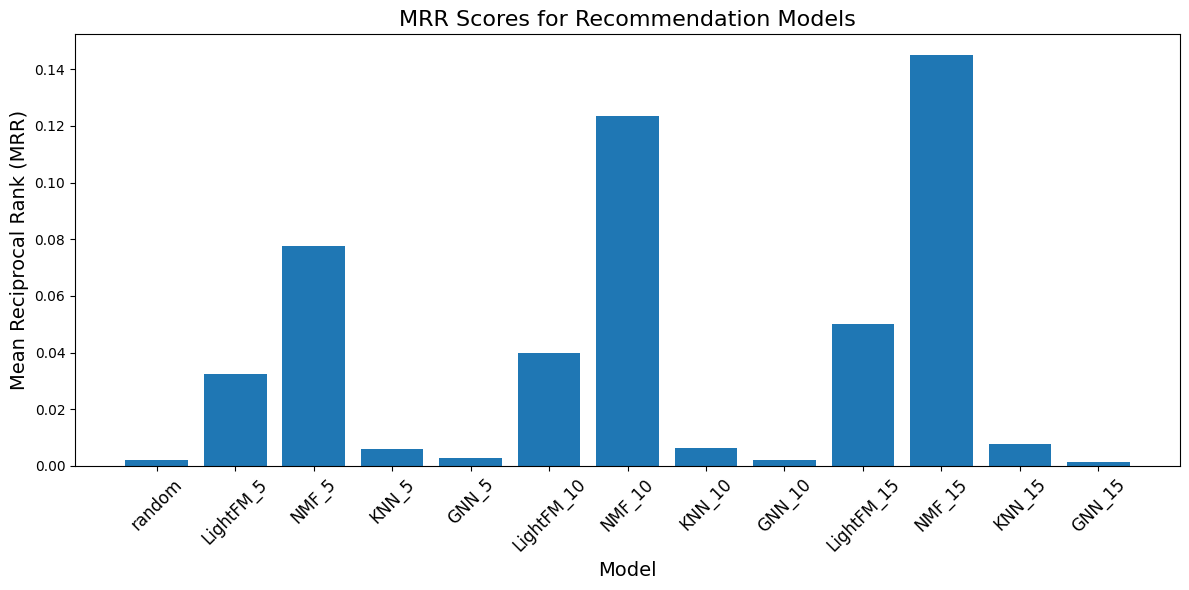

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Data loading: Load the favorite tracks for each user and the model recommendations from CSV files
favorite_tracks_df = pd.read_csv('users_tracks_shuffled.csv')

model_predictions = {
    'random': pd.read_csv('random_recommendations_20.csv'),
    'LightFM_5': pd.read_csv('user_recommendations_LightFM_5.csv'),
    'NMF_5': pd.read_csv('user_recommendations_NMF_5.csv'),
    'KNN_5': pd.read_csv('user_recommendations_KNN_5.csv'),
    'GNN_5': pd.read_csv('user_recommendations_GNN_5.csv'),
    'LightFM_10': pd.read_csv('user_recommendations_LightFM_10.csv'),
    'NMF_10': pd.read_csv('user_recommendations_NMF_10.csv'),
    'KNN_10': pd.read_csv('user_recommendations_KNN_10.csv'),
    'GNN_10': pd.read_csv('user_recommendations_GNN_10.csv'),
    'LightFM_15': pd.read_csv('user_recommendations_LightFM_15.csv'),
    'NMF_15': pd.read_csv('user_recommendations_NMF_15.csv'),
    'KNN_15': pd.read_csv('user_recommendations_KNN_15.csv'),
    'GNN_15': pd.read_csv('user_recommendations_GNN_15.csv')
}

# Function to calculate Mean Reciprocal Rank (MRR) for a single model
def calculate_mrr(model_df, favorite_tracks_df):
    mrr = 0  # Initialize MRR sum
    user_count = 0  # Counter for the number of users with recommendations

    # Iterate through each user in the favorite tracks dataset
    for user_id in favorite_tracks_df['user_id']:
        # Skip if user_id is not found in the model's recommendations
        if user_id not in model_df['user'].values:
            continue

        # Get the list of recommended tracks for the user
        recommendations = model_df[model_df['user'] == user_id].iloc[0, 1:].values
        # Get the user's list of favorite tracks (last 10 favorites)
        favorite_tracks = favorite_tracks_df[favorite_tracks_df['user_id'] == user_id].iloc[0, -5:].values

        # Initialize reciprocal rank
        reciprocal_rank = 0
        # Check each recommended track's rank
        for rank, rec_track in enumerate(recommendations, start=1):
            # If the recommended track is in the user's favorite list, set reciprocal rank and break
            if rec_track in favorite_tracks:
                reciprocal_rank = 1 / rank
                break

        # Add the user's reciprocal rank to MRR sum and increase user count
        mrr += reciprocal_rank
        user_count += 1

    # Calculate and return the average MRR for all users
    return mrr / user_count if user_count > 0 else 0

# Calculate MRR for each recommendation model
mrr_scores = {}
for model_name, predictions_df in model_predictions.items():
    mrr = calculate_mrr(predictions_df, favorite_tracks_df)
    mrr_scores[model_name] = mrr
    print(f"MRR for model {model_name}: {mrr:.5f}")

# Visualization: Bar chart for MRR scores
plt.figure(figsize=(12, 6))
plt.bar(mrr_scores.keys(), mrr_scores.values())
plt.title('MRR Scores for Recommendation Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Reciprocal Rank (MRR)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Save the plot or display it
plt.savefig('mrr_scores_bar_chart.png')  # Save to file
plt.show()  # Display the chart
